### References

**Book:**
- Deep Learning with Python, Second Edition
  - Book by François Chollet
  - François Chollet is a French software engineer and artificial intelligence researcher currently working at Google. Chollet is the creator of the Keras deep-learning library, released in 2015, and a main contributor to the TensorFlow machine learning framework.


### Code

In [29]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import boston_housing

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Loading data
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

57026/57026 [==============================] - 0s 3us/step


In [3]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [5]:
train_data[:2]

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, 0.00000e+00, 5.38000e-01,
        6.14200e+00, 9.17000e+01, 3.97690e+00, 4.00000e+00, 3.07000e+02,
        2.10000e+01, 3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, 0.00000e+00, 4.15000e-01,
        7.61000e+00, 1.57000e+01, 6.27000e+00, 2.00000e+00, 3.48000e+02,
        1.47000e+01, 3.95380e+02, 3.11000e+00]])

In [6]:
train_targets[:2]

array([15.2, 42.3])

In [8]:
# Normalizing the data

# Calculating mean and standard deviation
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

print(mean,"\n")
print(std,"\n")

# Subtracting mean and dividing by standard deviation
train_data -= mean
test_data -= mean

train_data /= std
test_data /= std

[3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01] 

[9.22929073e+00 2.37382770e+01 6.80287253e+00 2.40939633e-01
 1.17147847e-01 7.08908627e-01 2.79060634e+01 2.02770050e+00
 8.68758849e+00 1.66168506e+02 2.19765689e+00 9.39946015e+01
 7.24556085e+00] 



In [12]:
# Model and Compilation

# Because we need to instantiate the same model multiple times, we use a function to construct it
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
        ])

    # We are using both MSE and MAE
    # MSE for loss calculation and backpropagation
    # MAE as metric
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

**Validating your approach using K-fold validation**

To evaluate our model while we keep adjusting its parameters (such as the number of epochs used for training), we could split the data into a training set and a validation set, as we did in the previous examples.

But because we have so few data points, the validation set would end up being very small (for instance, about 100 examples). 

As a consequence, the validation scores might change a lot depending on which data points we chose for validation and which we chose for training: the validation scores might have a high variance with regard to the validation split.

This would prevent us from reliably evaluating our model.

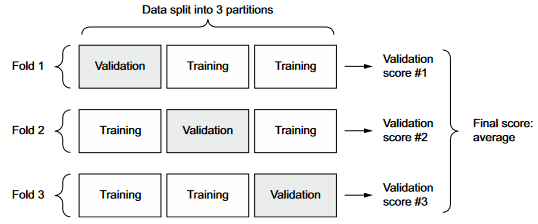

In [13]:
# K-fold validation

# Number of folds
k = 4

# Number of validation samples
num_val_samples = len(train_data) // k

# Epoch
num_epochs = 100

# List to store the scores
all_scores = []

for i in range(k):
    print(f"Processing fold #{i}")

    # Separating validation data from train data
    # Example: 0-24; 25-49; 49-74; 75-99
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Combining remaining data for training after extracting validation data
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                         axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                            axis=0)
    # Build the model
    model = build_model()

    # Fit the data
    model.fit(partial_train_data, 
              partial_train_targets,
              epochs=num_epochs,
              batch_size=16,
              verbose=0)
    
    # Collecting MSE and MAE
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)

    # Appending the MAE in the list
    all_scores.append(val_mae)

Processing fold #0




Processing fold #1
Processing fold #2
Processing fold #3


In [16]:
# MAE score for all the folds
print(all_scores)

[1.848280668258667, 2.5090792179107666, 2.4896109104156494, 2.2880654335021973]


In [17]:
# Mean score
print(np.mean(all_scores))

2.28375905752182


The different runs do indeed show rather different validation scores, from 1.8 to 2.5.

The average (2.28) is a much more reliable metric than any single score—that’s the entire point of K-fold cross-validation. 

In this case, we’re off by $2,280 on average, which is significant considering that the prices range from $10,000 to $50,000

We will modify the training loop to keep a record of how well the model does at each epoch

In [19]:
# Saving the validation logs at each fold

# Number of folds
k = 4

# Number of validation samples
num_val_samples = len(train_data) // k

# Epoch
num_epochs = 100

# List to store the scores
all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i}")

    # Separating validation data from train data
    # Example: 0-24; 25-49; 49-74; 75-99
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Combining remaining data for training after extracting validation data
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                         axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                            axis=0)
    # Build the model
    model = build_model()

    # Fit the data
    history = model.fit(partial_train_data, 
                        partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs,
                        batch_size=16,
                        verbose=0)
    
    # MAE history of each epoch
    mae_history  = history.history["val_mae"]

    # Appending the MAE history of each epoch in the list
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [22]:
# Number of folds
print(len(all_mae_histories))

# Number of epochs per fold
print(len(all_mae_histories[0]))

4
100


In [26]:
# Average MAE calculated for each epoch for all the folds  
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

print(len(average_mae_history))
print(average_mae_history)

100
[19.486626148223877, 16.274983167648315, 12.238120794296265, 8.340165257453918, 6.007471561431885, 4.8397825956344604, 4.128128826618195, 3.7250571250915527, 3.5125633478164673, 3.401131510734558, 3.2500977516174316, 3.142914295196533, 3.0672147274017334, 3.0071561336517334, 2.932457745075226, 2.8724393248558044, 2.861374080181122, 2.756864070892334, 2.7484609484672546, 2.6846120953559875, 2.6799829602241516, 2.6881922483444214, 2.636904239654541, 2.6369788646698, 2.586900293827057, 2.5769549012184143, 2.5240830779075623, 2.573797583580017, 2.6148608326911926, 2.592672348022461, 2.455711245536804, 2.5401520133018494, 2.512517213821411, 2.542300760746002, 2.4699137210845947, 2.5002732276916504, 2.475988745689392, 2.4857097268104553, 2.471139430999756, 2.432654619216919, 2.4074732065200806, 2.428069055080414, 2.4287341237068176, 2.4206900894641876, 2.424510270357132, 2.456139236688614, 2.436745524406433, 2.45607191324234, 2.4463301301002502, 2.3812200725078583, 2.4365672171115875, 2.

In [28]:
# Calculation loop beakdown
print((all_mae_histories[0][0] + all_mae_histories[1][0] + all_mae_histories[2][0] + all_mae_histories[3][0])/4)
print((all_mae_histories[0][1] + all_mae_histories[1][1] + all_mae_histories[2][1] + all_mae_histories[3][1])/4)

19.486626148223877
16.274983167648315


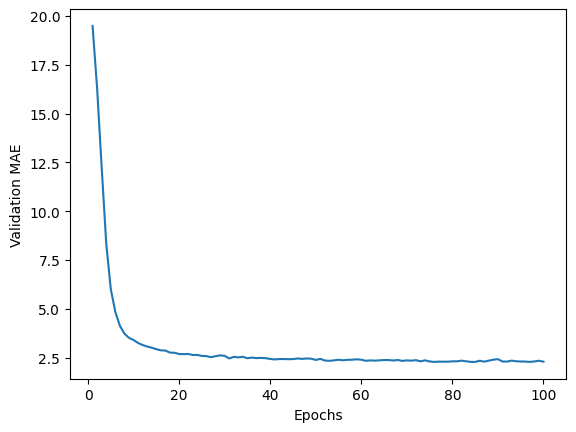

In [30]:
# Plotting validation scores

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

It may be a little difficult to read the plot, due to a scaling issue: the validation MAE for the first few epochs is dramatically higher than the values that follow. 

Let’s omit the first 10 data points, which are on a different scale than the rest of the curve.

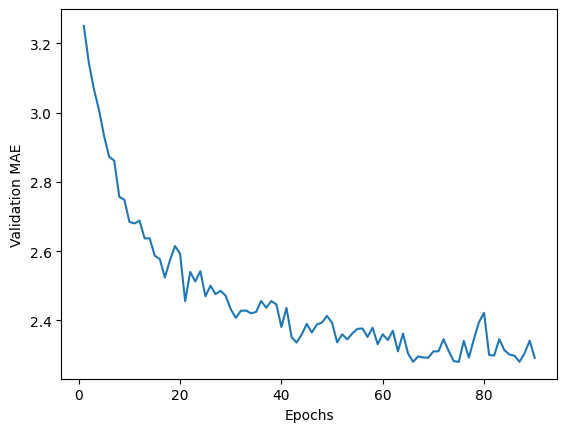

In [32]:
# Plotting validation scores, excluding the first 10 data points

truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [37]:
# Training for 150 epochs

k = 4

# Number of validation samples
num_val_samples = len(train_data) // k

# Epoch
num_epochs = 150

# List to store the scores
all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i}")

    # Separating validation data from train data
    # Example: 0-24; 25-49; 49-74; 75-99
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Combining remaining data for training after extracting validation data
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                         axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                            axis=0)
    # Build the model
    model = build_model()

    # Fit the data
    history = model.fit(partial_train_data, 
                        partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs,
                        batch_size=16,
                        verbose=0)
    
    # MAE history of each epoch
    mae_history  = history.history["val_mae"]

    # Appending the MAE history of each epoch in the list
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [38]:
# Number of folds
print(len(all_mae_histories))

# Number of epochs per fold
print(len(all_mae_histories[0]))

4
150


In [40]:
# Average MAE calculated for each epoch for all the folds  
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

print(len(average_mae_history))
print(average_mae_history)

150
[19.385831356048584, 15.986101865768433, 11.84698486328125, 8.250986695289612, 5.956215023994446, 4.869604766368866, 4.3233665227890015, 3.984166383743286, 3.741111159324646, 3.544448137283325, 3.3840858340263367, 3.2545849680900574, 3.162145972251892, 3.05876886844635, 2.992958426475525, 2.950575530529022, 2.952044188976288, 2.8314945697784424, 2.8030781745910645, 2.8162366151809692, 2.763177812099457, 2.7288551330566406, 2.6793784499168396, 2.656724274158478, 2.6630954146385193, 2.606927514076233, 2.616633176803589, 2.614355504512787, 2.5561729073524475, 2.580515503883362, 2.536662518978119, 2.526725649833679, 2.60886013507843, 2.5828245878219604, 2.5594218373298645, 2.4810884594917297, 2.519672453403473, 2.490498185157776, 2.461668848991394, 2.52372807264328, 2.5420417189598083, 2.5199567079544067, 2.476581633090973, 2.4733031392097473, 2.509898841381073, 2.4308023750782013, 2.4758627712726593, 2.386875867843628, 2.4193845093250275, 2.4152694642543793, 2.468985080718994, 2.43527

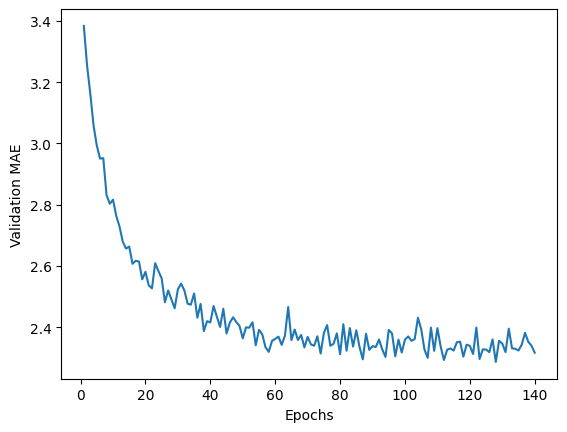

In [41]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [43]:
# Training for 500 epochs

k = 4

# Number of validation samples
num_val_samples = len(train_data) // k

# Epoch
num_epochs = 500

# List to store the scores
all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i}")

    # Separating validation data from train data
    # Example: 0-24; 25-49; 49-74; 75-99
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Combining remaining data for training after extracting validation data
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                         axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                            axis=0)
    # Build the model
    model = build_model()

    # Fit the data
    history = model.fit(partial_train_data, 
                        partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs,
                        batch_size=16,
                        verbose=0)
    
    # MAE history of each epoch
    mae_history  = history.history["val_mae"]

    # Appending the MAE history of each epoch in the list
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [44]:
# Number of folds
print(len(all_mae_histories))

# Number of epochs per fold
print(len(all_mae_histories[0]))

4
500


In [45]:
# Average MAE calculated for each epoch for all the folds  
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

print(len(average_mae_history))
print(average_mae_history)

500
[19.359565258026123, 15.893268823623657, 11.694863080978394, 7.714258313179016, 5.654409408569336, 4.642620861530304, 4.109501898288727, 3.7682542204856873, 3.5990196466445923, 3.3853803277015686, 3.280836343765259, 3.1495124101638794, 3.038302183151245, 2.962185263633728, 2.9057223200798035, 2.9346536993980408, 2.84615558385849, 2.7881839275360107, 2.741327702999115, 2.7317943572998047, 2.6582605838775635, 2.636415719985962, 2.6219522953033447, 2.598543107509613, 2.6438194513320923, 2.5652822852134705, 2.539425492286682, 2.629718065261841, 2.5115760564804077, 2.587310254573822, 2.5480555295944214, 2.55953848361969, 2.4870479106903076, 2.509845197200775, 2.5256184935569763, 2.480453610420227, 2.465330481529236, 2.5425687432289124, 2.4815555214881897, 2.436073362827301, 2.4152305126190186, 2.476861894130707, 2.442401945590973, 2.414038836956024, 2.4700493812561035, 2.4106002748012543, 2.419728398323059, 2.4558109045028687, 2.4523115754127502, 2.4077873826026917, 2.440276324748993, 2

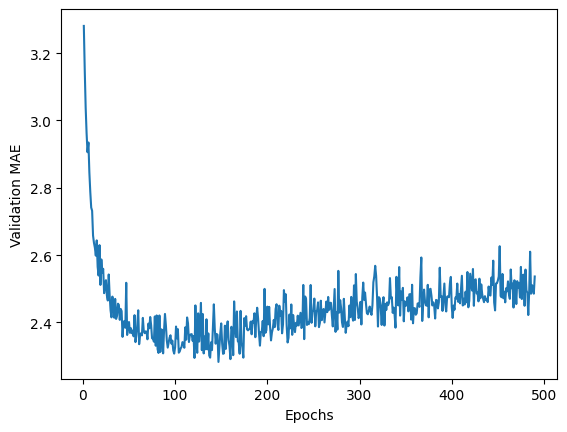

In [46]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

As you can see validation MAE stops improving significantly after 120–140 epochs (this number includes the 10 epochs we omitted). 

Past that point, we start overfitting.

Once you’re finished tuning other parameters of the model (in addition to the number of epochs, you could also adjust the size of the intermediate layers), you can train a final production model on all of the training data, with the best parameters, and then look at its performance on the test data

In [47]:
# Training the final model

model = build_model()
model.fit(train_data, train_targets,epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 0s/step - loss: 15.9887 - mae: 2.5989


In [48]:
# Prediction on new data - We are using test data only

predictions = model.predict(test_data)
print(predictions[0:10])

4/4 [==============================] - 0s 0s/step
[[ 7.602556]
 [18.453499]
 [21.514357]
 [34.5492  ]
 [24.511818]
 [21.27626 ]
 [26.449337]
 [21.606707]
 [18.47475 ]
 [22.888355]]


In [49]:
# Looking at targets

print(test_targets[:10])

[ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2]
